In [23]:
import pandas as pd 
from matplotlib import pyplot as plt 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import seaborn as sbn

In [2]:
# NOTE: WE only consider the top 1000 DTI predictions
neg_preds = pd.read_csv('../output/tkg/TKGDTI_negative_predictions.csv', low_memory=False).head(1000)
neg_preds.head()

,prot_name,prob,global_rank,drug_rank,inhibitor,inchikey,in_clue,in_stitch,stitch_score,drug_idx,prot_idx,in_targetome,kd_score,hi_expr_in_aml,no_expr_in_aml
0,PDGFRB,0.935497,1.0,1.0,Ponatinib (AP24534),PHXJVRSECIGDHY-UHFFFAOYSA-N,False,True,869.0,10.0,8287.0,False,-0.178599,False,False
1,KIT,0.934837,2.0,1.0,Sorafenib,MLDQJTXFUGDVEO-UHFFFAOYSA-N,True,True,997.0,29.0,5631.0,False,-0.515318,True,False
2,PDGFRA,0.934530,3.0,2.0,Sorafenib,MLDQJTXFUGDVEO-UHFFFAOYSA-N,False,True,994.0,29.0,8286.0,False,-0.184081,False,False
3,PDGFRB,0.933046,4.0,1.0,AST-487,ODPGGGTTYSGTGO-UHFFFAOYSA-N,False,False,NaN,4.0,8287.0,False,-0.142838,False,False
4,FLT3,0.932110,5.0,1.0,Motesanib (AMG-706),RAHBGWKEPAQNFF-UHFFFAOYSA-N,False,True,788.0,28.0,3804.0,False,0.087434,True,False


In [3]:
resp = pd.read_csv('../data/tkg_raw/beataml_probit_curve_fits_v4_dbgap.txt', sep='\t')[lambda x: (x.converged) & (x.curve_type == 'decreasing') & (x.type == 'single-agent')]
resp.head()

,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,inhibitor,type,status,paper_inclusion,min_conc,max_conc,intercept,...,converged,ic10,ic25,ic50,ic75,ic90,auc,all_gt_50,all_lt_50,curve_type
0,2476,NaN,BA3073R,Axitinib (AG-013736),single-agent,train/test,True,0.0137,10,-0.145371,...,True,0.013700,0.075364,0.632206,5.303377,10.000000,159.484594,False,False,decreasing
2,2476,NaN,BA3073R,Crizotinib (PF-2341066),single-agent,train/test,True,0.0137,10,-0.393883,...,True,0.022507,0.088986,0.409960,1.887455,7.462260,146.947463,False,False,decreasing
3,2476,NaN,BA3073R,Dasatinib,single-agent,train/test,True,0.0014,1,-0.153187,...,True,0.001705,0.025291,0.506219,1.000000,1.000000,201.043243,False,False,decreasing
4,2476,NaN,BA3073R,Erlotinib,single-agent,train/test,True,0.0137,10,-0.220735,...,True,0.034847,0.135294,0.610660,2.756260,10.000000,161.789024,False,False,decreasing
5,2476,NaN,BA3073R,Gefitinib,single-agent,train/test,True,0.0137,10,-0.442359,...,True,0.016818,0.070882,0.350537,1.733322,7.306475,141.189411,False,False,decreasing


In [4]:
expr = pd.read_csv('../data/tkg_raw/beataml_waves1to4_norm_exp_dbgap.txt', sep='\t')
expr = expr[['display_label'] + list(expr.columns[4:])]
expr = expr.groupby('display_label').mean().reset_index()
expr = expr.set_index('display_label')
expr.head()

,BA2392R,BA2611R,BA2506R,BA2430R,BA2448R,BA2730R,BA2845R,BA2326R,BA2341R,BA2612R,...,BA3376R,BA3137R,BA3300R,BA3375R,BA3249R,BA3385R,BA3242R,BA3446R,BA3416R,BA3123R
display_label,,,,,,,,,,,,,,,,,,,,,
A1BG,-0.437849,-0.802256,-1.073553,-0.851051,-1.303086,-1.453400,-1.253583,-1.086206,-0.581670,-1.110554,...,-0.286764,-1.733767,-0.697874,-0.692659,0.722208,-1.030400,-1.215052,-0.681448,0.939179,-1.095599
A1BG-AS1,3.027652,3.030494,3.406264,3.178920,3.077002,3.171882,2.885846,2.904771,2.964675,2.663079,...,3.864986,1.964441,2.970402,3.557071,3.458577,4.243161,4.084791,4.214817,4.160494,4.016022
A2M,1.472384,1.738676,1.229445,1.595418,1.578374,1.222287,1.192150,1.398392,1.024968,1.402800,...,-3.190298,0.678778,-3.628236,-3.679694,-4.713417,-2.477474,-0.592151,-4.857657,-2.488578,-2.707306
A2M-AS1,2.442338,2.629291,2.391195,2.788864,2.350741,2.609716,2.445834,2.281909,2.472264,2.497831,...,2.969235,1.683273,-0.923452,2.694741,2.028376,-0.382770,1.218666,0.187685,-0.725313,2.930180
A2ML1,-7.506062,-3.720447,-5.261791,-3.486004,-4.042784,-5.069402,-6.977352,-7.506062,-7.506062,-4.924950,...,-5.520913,-6.310164,-5.321829,-5.321829,-4.947309,-4.365236,-4.529096,-5.174893,-3.328538,-6.739802


In [7]:
import warnings

warnings.filterwarnings('ignore')

expr_res = {'inhibitor': [], 'gene': [], 'r': [], 'pval':[], 'N':[]}
for i,row in neg_preds.iterrows(): 

    gene = row.prot_name 
    drug = row.inhibitor 

    # expr 
    if gene not in expr.index: 
        continue 
    
    x = expr.loc[gene]
    y = resp[lambda x: x.inhibitor == drug]

    tmp = y[['dbgap_rnaseq_sample', 'auc']].set_index('dbgap_rnaseq_sample').merge(x, left_index=True, right_index=True)

    # zscore expr 
    tmp[gene] = (tmp[gene] - tmp[gene].mean()) / tmp[gene].std()

    try: 
        model = ols(f'auc ~ {gene}', data=tmp).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        p_value = anova_table['PR(>F)'][0]
    except: 
        p_value = None
    
    r = tmp.corr('spearman').values[0,1]

    expr_res['inhibitor'].append(drug)
    expr_res['gene'].append(gene)
    expr_res['r'].append(r)
    expr_res['pval'].append(p_value)
    expr_res['N'].append(tmp.shape[0])

expr_res = pd.DataFrame(expr_res).dropna().sort_values('r', ascending=False)
expr_res['pval_adj'] = multipletests(expr_res['pval'], method='fdr_bh')[1]

expr_res = expr_res.sort_values('pval_adj').reset_index(drop=True)
expr_res.to_csv('/mnt/c/Users/natha/Documents/TKGDTI_negative_predictions_resp-expr_correlation.csv', index=False)
expr_res.head(10)


,inhibitor,gene,r,pval,N,pval_adj
0,Venetoclax,ERBB2,-0.494368,2.639261e-22,335,2.259207e-19
1,Sorafenib,STK17A,0.289622,1.030308e-11,479,4.409719e-09
2,Cabozantinib,FLT3,-0.308482,2.497720e-11,437,7.126827e-09
3,Venetoclax,FLT3,-0.377574,1.012682e-10,335,2.167140e-08
4,LY-333531,FLT3,-0.307209,7.716336e-10,408,1.321037e-07
5,KW-2449,ABL2,-0.321102,3.435815e-09,397,4.901762e-07
6,Sorafenib,ABL2,-0.247151,6.841434e-09,479,8.366097e-07
7,Sorafenib,CDKL3,-0.257291,1.269631e-08,479,1.086804e-06
8,Dasatinib,CSF1R,-0.253868,1.225664e-08,433,1.086804e-06
9,Doramapimod (BIRB 796),JAK2,-0.279412,1.239500e-08,412,1.086804e-06


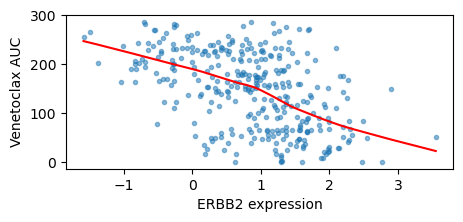

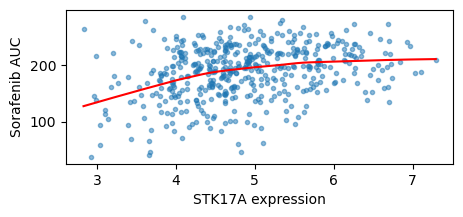

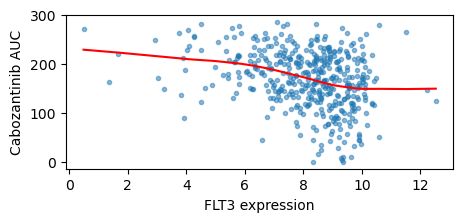

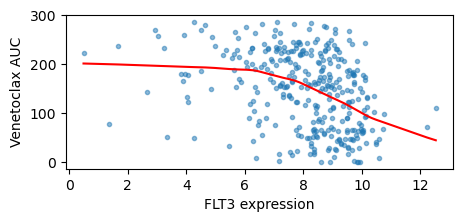

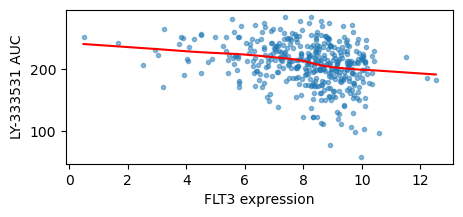

In [8]:

for i,row in expr_res.head(5).iterrows(): 

    gene = row.gene
    drug = row.inhibitor 

    # expr 
    if gene not in expr.index: 
        continue 
    
    x = expr.loc[gene]
    y = resp[lambda x: x.inhibitor == drug]

    tmp = y[['dbgap_rnaseq_sample', 'auc']].set_index('dbgap_rnaseq_sample').merge(x, left_index=True, right_index=True)

    lowess_result = lowess(tmp['auc'], tmp[gene])
    
    plt.figure(figsize=(5,2))
    plt.plot(tmp[gene], tmp['auc'], '.', alpha=0.5)
    plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red')
    plt.xlabel(gene + ' expression')
    plt.ylabel(drug + ' AUC')
    plt.show() 
    




In [9]:
mut = pd.read_csv('../data/tkg_raw/beataml_wes_wv1to4_mutations_dbgap.txt', sep='\t')
mut = mut[['dbgap_sample_id', 'gene', 'symbol', 'variant_classification', 'sift', 'polyphen']].drop_duplicates()
mut.head()

,dbgap_sample_id,gene,symbol,variant_classification,sift,polyphen
0,BA2336D,ENSG00000168769,TET2,frameshift_variant,NaN,NaN
2,BA2336D,ENSG00000181163,NPM1,frameshift_variant,NaN,NaN
3,BA2643D,ENSG00000184937,WT1,frameshift_variant,NaN,NaN
4,BA2643D,ENSG00000119772,DNMT3A,missense_variant,deleterious(0),probably_damaging(0.993)
6,BA2067D,ENSG00000139083,ETV6,frameshift_variant,NaN,NaN


In [10]:
mut.variant_classification.unique()

array(['frameshift_variant', 'missense_variant', 'stop_gained',
       'inframe_deletion', 'protein_altering_variant',
       'splice_acceptor_variant', 'splice_donor_variant', 'start_lost',
       'inframe_insertion', 'stop_lost'], dtype=object)

In [11]:
mut = mut.assign(polyphen_short = lambda x: x.polyphen.str.split('(').str[0])
mut.head()

,dbgap_sample_id,gene,symbol,variant_classification,sift,polyphen,polyphen_short
0,BA2336D,ENSG00000168769,TET2,frameshift_variant,NaN,NaN,NaN
2,BA2336D,ENSG00000181163,NPM1,frameshift_variant,NaN,NaN,NaN
3,BA2643D,ENSG00000184937,WT1,frameshift_variant,NaN,NaN,NaN
4,BA2643D,ENSG00000119772,DNMT3A,missense_variant,deleterious(0),probably_damaging(0.993),probably_damaging
6,BA2067D,ENSG00000139083,ETV6,frameshift_variant,NaN,NaN,NaN


In [15]:
import warnings

warnings.filterwarnings('ignore')

mut_res = {'inhibitor': [], 'gene': [], 'r': [], 'pval':[], 'N':[], 'N_mut':[]}
for i,row in neg_preds.iterrows(): 

    gene = row.prot_name 
    drug = row.inhibitor 
    
    x = mut[lambda x: (x.symbol == gene)]#& (x.polyphen_short == 'probably_damaging')]

    if x.shape[0] < 3: 
        continue 

    y = resp[lambda x: x.inhibitor == drug]

    tmp = x[['dbgap_sample_id']].assign(mut=True).merge(y[['dbgap_dnaseq_sample', 'auc']], left_on='dbgap_sample_id', right_on='dbgap_dnaseq_sample', how='right')[['mut', 'auc']].fillna(False) 

    try: 
        tmp['mut'] = tmp['mut'].astype(int)  # Convert boolean to int for logistic regression
        model = sm.Logit(tmp['mut'], sm.add_constant(tmp['auc'])).fit(disp=0)
        p_value = model.pvalues[1]
    except: 
        p_value = None
    
    r = tmp.corr('spearman').values[0,1]

    mut_res['inhibitor'].append(drug)
    mut_res['gene'].append(gene)
    mut_res['r'].append(r)
    mut_res['pval'].append(p_value)
    mut_res['N'].append(tmp.shape[0])
    mut_res['N_mut'].append(tmp.mut.sum())

mut_res = pd.DataFrame(mut_res).dropna().sort_values('r', ascending=False)
mut_res['pval_adj'] = multipletests(mut_res['pval'], method='fdr_bh')[1]

mut_res = mut_res.sort_values('pval_adj').reset_index(drop=True)
mut_res.to_csv('/mnt/c/Users/natha/Documents/TKGDTI_negative_predictions_resp-mut_correlation.csv', index=False)
mut_res.head(10)


,inhibitor,gene,r,pval,N,N_mut,pval_adj
0,Midostaurin,NRAS,0.277305,3.095765e-07,405,74,0.000042
1,Sorafenib,JAK2,0.119207,5.064508e-03,581,19,0.341854
2,LY-333531,FLT3,-0.130799,7.724061e-03,481,55,0.347583
3,Bosutinib (SKI-606),EPHA3,-0.031080,1.231092e-02,501,2,0.415494
4,Doramapimod (BIRB 796),JAK2,0.109125,1.975999e-02,480,17,0.533520
5,TG101348,DNMT3A,0.205084,2.372575e-02,110,18,0.533829
6,GSK690693,FLT3,0.131207,2.844899e-02,294,30,0.548659
7,ABT-737,KIT,0.136346,3.823184e-02,272,8,0.645162
8,Dasatinib,BRAF,0.088563,7.220063e-02,528,4,0.668255
9,PI-103,JAK2,0.078204,7.792222e-02,519,19,0.668255


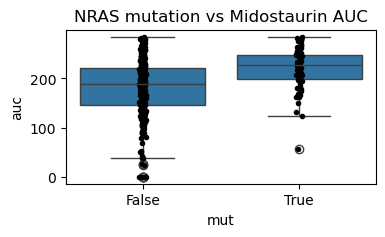

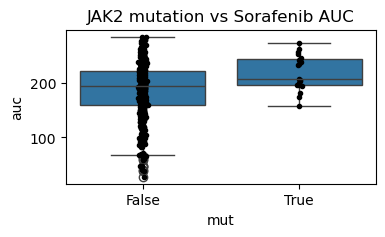

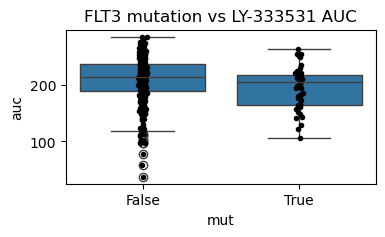

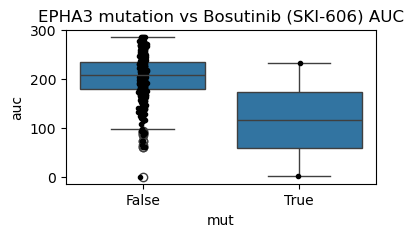

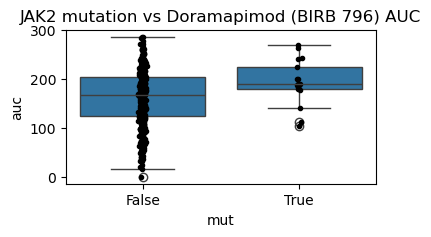

In [27]:

for i,row in mut_res.head(5).iterrows(): 
        
    x = mut[lambda x: x.symbol == row.gene]
    y = resp[lambda x: x.inhibitor == row.inhibitor]

    tmp = x[['dbgap_sample_id']].assign(mut=True).merge(y[['dbgap_dnaseq_sample', 'auc']], left_on='dbgap_sample_id', right_on='dbgap_dnaseq_sample', how='right')[['mut', 'auc']].fillna(False) 

    plt.figure(figsize=(4,2))
    plt.title(f'{row.gene} mutation vs {row.inhibitor} AUC')
    sbn.boxplot(x='mut', y='auc', data=tmp)
    plt.plot(tmp['mut'] + 0.01*np.random.randn(tmp.shape[0]), tmp['auc'], 'k.', alpha=1.)
    plt.show()

In [47]:
res = neg_preds.rename({'prot_name': 'gene'}, axis=1).merge(mut_res, on=['gene', 'inhibitor']).merge(expr_res, on=['gene', 'inhibitor'])
res = res[['gene', 'inhibitor', 'prob', 'global_rank', 'drug_rank', 'in_clue', 'in_stitch', 'pval_x', 'pval_y', 'hi_expr_in_aml', 'kd_score']]
res.head()

,gene,inhibitor,prob,global_rank,drug_rank,in_clue,in_stitch,pval_x,pval_y,hi_expr_in_aml,kd_score
0,KIT,Sorafenib,0.934837,2.0,1.0,True,True,0.136473,0.044133,True,-0.515318
1,FLT3,Motesanib (AMG-706),0.932110,5.0,1.0,False,True,0.519683,0.343467,True,0.087434
2,KIT,Imatinib,0.905576,15.0,2.0,True,True,0.085440,0.774353,True,-0.381547
3,KIT,Crenolanib,0.903603,19.0,1.0,False,False,0.065116,0.224902,True,-0.334086
4,FLT3,Cediranib (AZD2171),0.902113,20.0,2.0,False,False,0.053266,0.551019,True,-0.027038


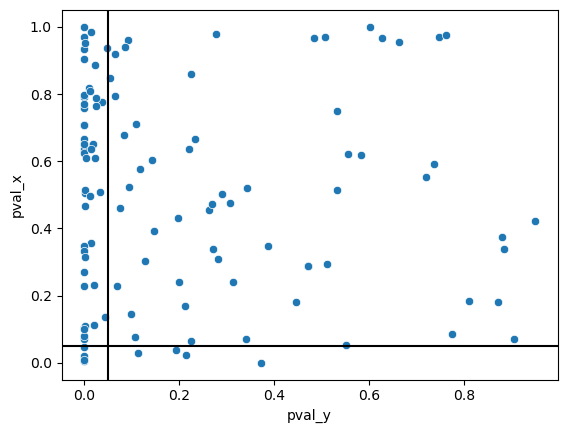

In [48]:
plt.figure()
sbn.scatterplot(x='pval_y', y='pval_x', data=res)
plt.axhline(0.05, c='k')
plt.axvline(0.05, c='k')
plt.show()

In [61]:
res[lambda x: ((x.pval_x < 0.05) | (x.pval_y < 0.05)) & ~x.in_clue & ~x.in_stitch].sort_values('prob', ascending=False).style.hide()

gene,inhibitor,prob,global_rank,drug_rank,in_clue,in_stitch,pval_x,pval_y,hi_expr_in_aml,kd_score
FLT3,Vatalanib (PTK787),0.881504,46.000000,2.000000,False,False,0.113785,0.020248,True,-0.258975
CDK13,Flavopiridol,0.858381,94.000000,2.000000,False,False,0.936422,0.048145,False,-0.432141
FLT3,Tivozanib (AV-951),0.821538,190.000000,7.000000,False,False,0.787391,0.024548,True,-0.088850
FLT3,GW-2580,0.804655,251.000000,4.000000,False,False,0.648803,0.017105,True,-0.380387
FLT3,Nilotinib,0.799245,267.000000,9.000000,False,False,0.649894,0.017755,True,-0.199351
FLT3,CYT387,0.793410,291.000000,1.000000,False,False,0.228404,0.000636,True,0.190497
CDK13,MLN120B,0.768539,475.000000,2.000000,False,False,0.818466,0.009504,False,-0.743891
JAK3,Canertinib (CI-1033),0.766517,494.000000,4.000000,False,False,0.346906,0.000453,True,-0.411840
CDK13,Sorafenib,0.766367,497.000000,15.000000,False,False,0.271052,0.000006,False,-0.245215
FLT3,Pelitinib (EKB-569),0.765854,499.000000,12.000000,False,False,0.079201,0.000000,True,0.112221
